TensorFlow 2 (TF2) provides a whole set of tools to implement machine learning to a wide range of problems, from preparing the data to deploying a model. In this post, I demonstrate how to use the package to build a regression model predicting continuous numerical values based on input data. 

The objective of this demo is to show you the main elements of working with a TF2 model to tackle regression problems.

## Setup

Important libraries are loaded, namely `tensorflow`, `numpy` to manipulate data, `pandas` to deal with table, and `seaborn` to create visualisation. As part of the setup, I also clean the `TF2` environment with `clear_session` function and set seed for random number generation using `set_random_seed` function.

For the visualisation, I attempted to use the `seaborn.objects` interface. The reason for this is that I am familiar with the `ggplot2` package in `R` when conducting data analysis, and I found that there is some similarity in both approach of creating a plot. For those who aren't familiar with `ggplot2` package, it employs the concept of [layered grammar of graphics](https://vita.had.co.nz/papers/layered-grammar.html) allowing you to describe any plots in a more structured way which result in more convenient and consistent code. You can see the documentations for the `seaborn.objects` interface [here](https://seaborn.pydata.org/tutorial/objects_interface) and the `ggplot2` package [here](https://ggplot2.tidyverse.org/). 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn.objects as so

In [2]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(123)

## Generate Random Data

For the sample problem, I generated a 1000 observations of random number with two independent variables $x_0$ and $x_1$. The target for prediction is calculated using simple formula below. 

$$
    y = f(x) = 0.2 \times x_0 + 2.8 \times x_1 + \epsilon 
$$

All variables $x_0$ and $x_1$ as well as the error term $\epsilon$ follow a normal distribution $N(\mu, \sigma^2)$ with $\mu = 0$ and $\sigma^2 = 1$. 

In [3]:
X = np.random.normal(size = (1000, 2))
y = 0.2 * X[:, 0] + 2.8 * X[:, 1] + np.random.normal(size = (1000,))

For evaluation of model, I split the data, 80% for training and 20% for testing. 

In [4]:
X_train = X[:800]
y_train = y[:800]
X_test = X[800:]
y_test = y[800:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((800, 2), (800,), (200, 2), (200,))

## A Very Simple `TF2` Model

### Defining the model

Defining a `TF2` model can be accomplished easily by calling the `Sequential` method, followed by `add`ing any types and number of layers. As the problem is very straightforward, tackling this should be relatively easy. For this reason, the model I defined here is very simple with only one `Dense` layer with one perceptron unit. In addition, we need to define the `input_shape` so that the model can determine the number of parameters it requires to predict all inputs. The `summary` method allows you to see the architecture of the model.

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape = (2, )))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Before training the model, you are required to choose the optimizer, loss function, and metrics, and `compile` those into the model. Here, I decided to use Stochastic Gradient Descent algorithm for optimizing the model (i.e., updating neural network parameters), Mean Squared Error (MSE) for determining how far the prediciton of the current model with actual values, and Mean Absolute Error (MAE) as a metric to evaluate the model.

In [6]:
model.compile(optimizer = "sgd", loss = "mse", metrics = ["mae"])

### Training the model

Training can be done using `fit` method. The process is done after 100 `epochs` or cycles of the model updating its parameters based on input data. The `verbose` parameter that equals 0 means that the training will not print any information.

In [7]:
history = model.fit(X_train, y_train, epochs = 100, verbose = 0)

The `fit` method returns `History` object, which provides you the performance of the model during training. The `history.history` contains all loss and metric scores for all training epochs, and you can extract this information to evalate your model. I performed some manipulation basically to have a certain format of data (the long version, you might want to refer to [tidy data by Hadley Wickham]()).

In [8]:
data = pd.DataFrame(history.history)
data = data.reset_index()
data = data.rename(columns = {
    "index":"epoch", 
    "loss": "Mean Squared Error", 
    "mae": "Mean Absolute Error"})
data = pd.melt(
    data, 
    id_vars = "epoch", 
    value_vars = ["Mean Squared Error", "Mean Absolute Error"],
    var_name = "metric",
    value_name = "value"
)

data.sort_values(by = "epoch").head()

,epoch,metric,value
0,0,Mean Squared Error,5.752564
100,0,Mean Absolute Error,1.881032
1,1,Mean Squared Error,2.836762
101,1,Mean Absolute Error,1.315763
2,2,Mean Squared Error,1.707698


We can then visualise how the model perform throughout the training.

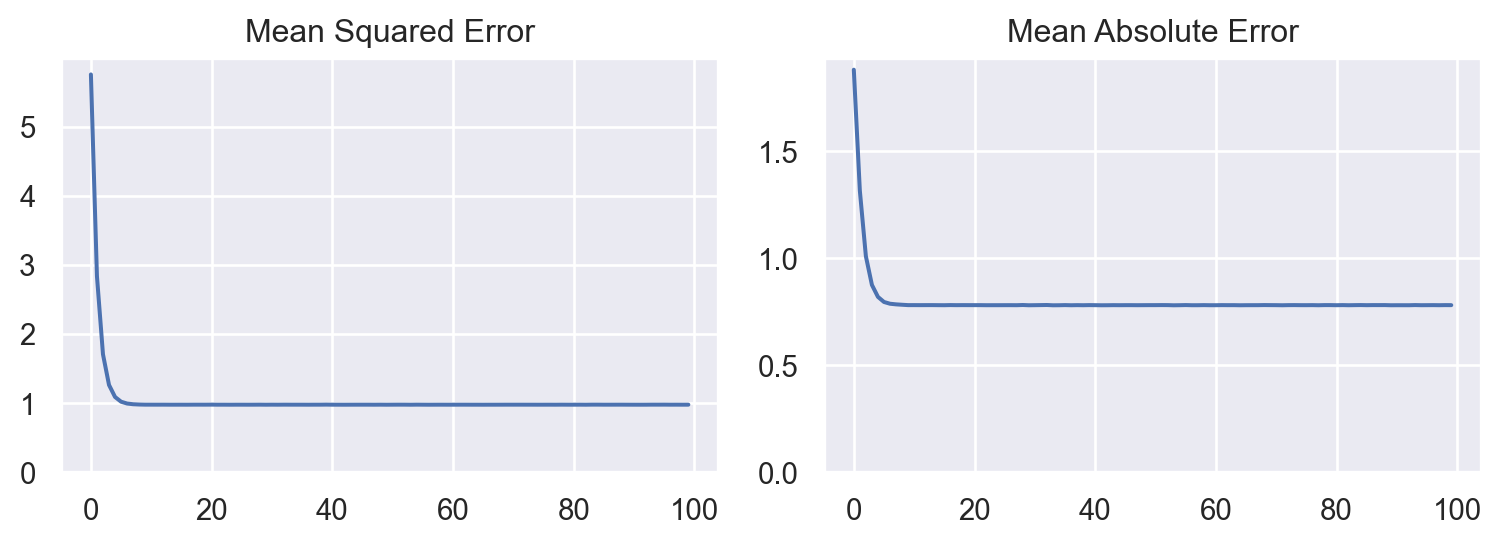

In [9]:
#| fig-align: center

(
    so.Plot(data, x = "epoch", y = "value")
    .facet("metric")
    .add(so.Line())
    .share(y = False)
    .limit(y = (0, None))
    .layout(size = (8, 3))
    .label(x = "", y = "")
)

### Evaluating the model

Finally, we can check the model's performance on the test dataset. The `evaluate` method allows the users to see how the model perform when predicting unseen data. The model seems to do good in predicting the actual output based on the MSE and MAE.

In [10]:
mse, mae = model.evaluate(X_test, y_test, verbose = 0)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error : 0.90
Mean Absolute Error: 0.77


## Dealing with Non-linearity

It is well known that deep learning models are good for high dimensional and complex data. To illustrate the capability of a model in dealing with that type of data, I slightly modified the problem by squaring `x_1`, giving a non-linear property to the data. The final formula is presented below.

$$
    y = f(x) = 0.2 \times x_0 + 2.8 \times x_1^2 + \epsilon 
$$

All variables $x_0$ and $x_1$ as well as the error term $\epsilon$ follow a normal distribution $N(\mu, \sigma^2)$ with $\mu = 0$ and $\sigma^2 = 1$. 

In [11]:
X = np.random.normal(size = (1000, 2))
y = 0.2 * X[:, 0] + 2.8 * X[:, 1] ** 2 + np.random.normal(size = (1000,))

X_train = X[:800]
y_train = y[:800]
X_test = X[800:]
y_test = y[800:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((800, 2), (800,), (200, 2), (200,))

Using the same approach as above might not give you the best result as you can see in the graphs below. Both MSE and MAE can be significantly higher compared to the values from the previous problem.

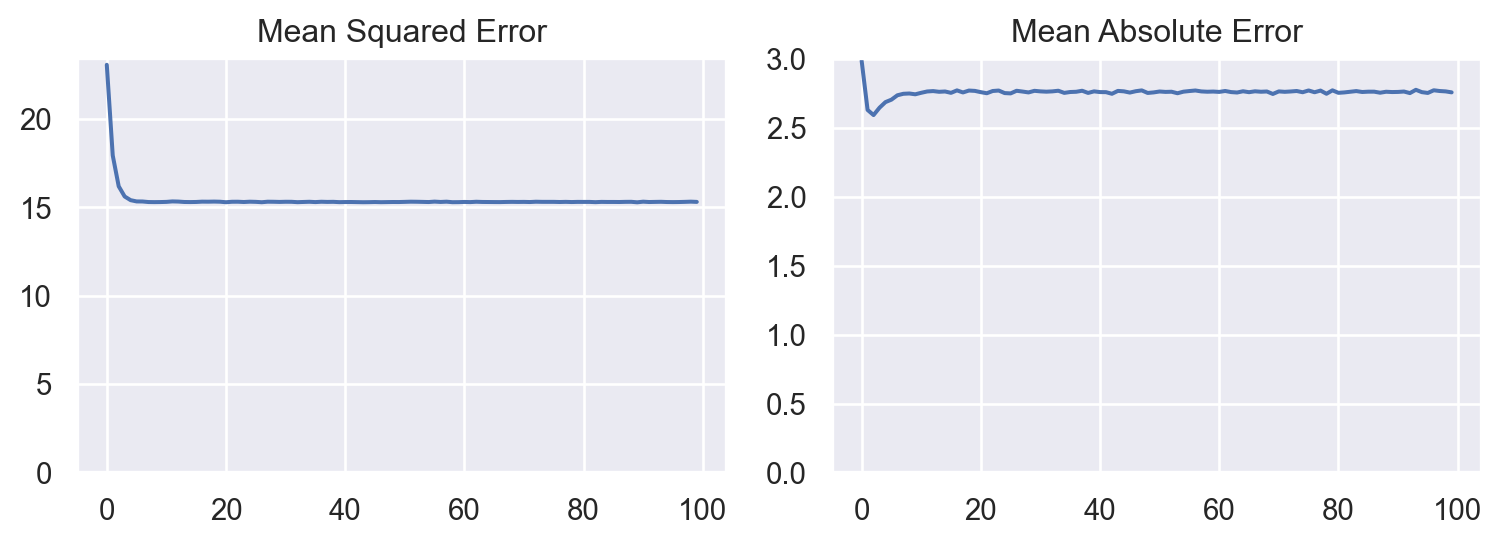

In [12]:
#| fig-align: center
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape = (2, )))
model.compile(optimizer = "sgd", loss = "mse", metrics = ["mae"])
history = model.fit(X_train, y_train, epochs = 100, verbose = 0)

data = pd.DataFrame(history.history)
data = data.reset_index()
data = data.rename(columns = {"index":"epoch", 
                              "loss": "Mean Squared Error", 
                              "mae": "Mean Absolute Error"})
data = pd.melt(data, 
               id_vars = "epoch", 
               value_vars = ["Mean Squared Error", "Mean Absolute Error"],
               var_name = "metric",
               value_name = "value")

(
    so.Plot(data, x = "epoch", y = "value")
    .facet("metric")
    .add(so.Line())
    .share(y = False)
    .limit(y = (0, None))
    .layout(size = (8, 3))
    .label(x = "", y = "")
)

In [13]:
mse, mae = model.evaluate(X_test, y_test, verbose = 0)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error : 14.94
Mean Absolute Error: 2.75


## Going Deeper by Using More Layers

As the name suggests, Deep Learning techniques leverages several intermediate representation of the data before finally decide what value to assign for any given input. This supports finding complex patterns that are usually inherent in real world data. 

The previous model is modified simply by `add`ing more `Dense` layers and increasing the number of the units. The `activation` function in a model is crucial for capturing non-linearity. The `relu` activation function is a function that gives either a positive value or zero which is suprisingly effective for balancing the trade-offs between finding non-linear pattern and efficient computation. As each subsequent layer can determine the number of parameters required through inferring the number of units from the previous layer, `input_shape` is only defined for the first layer.  

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, activation = "relu", input_shape = (2, )))
model.add(tf.keras.layers.Dense(32, activation = "relu"))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer = "sgd", loss = "mse", metrics = ["mae"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                96        
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


As can be seen in the plots below and the values of MSE and MAE, the 'deeper' version of the model could better capture the inherent trend of the dataset leading to more superior model than the previous one. 

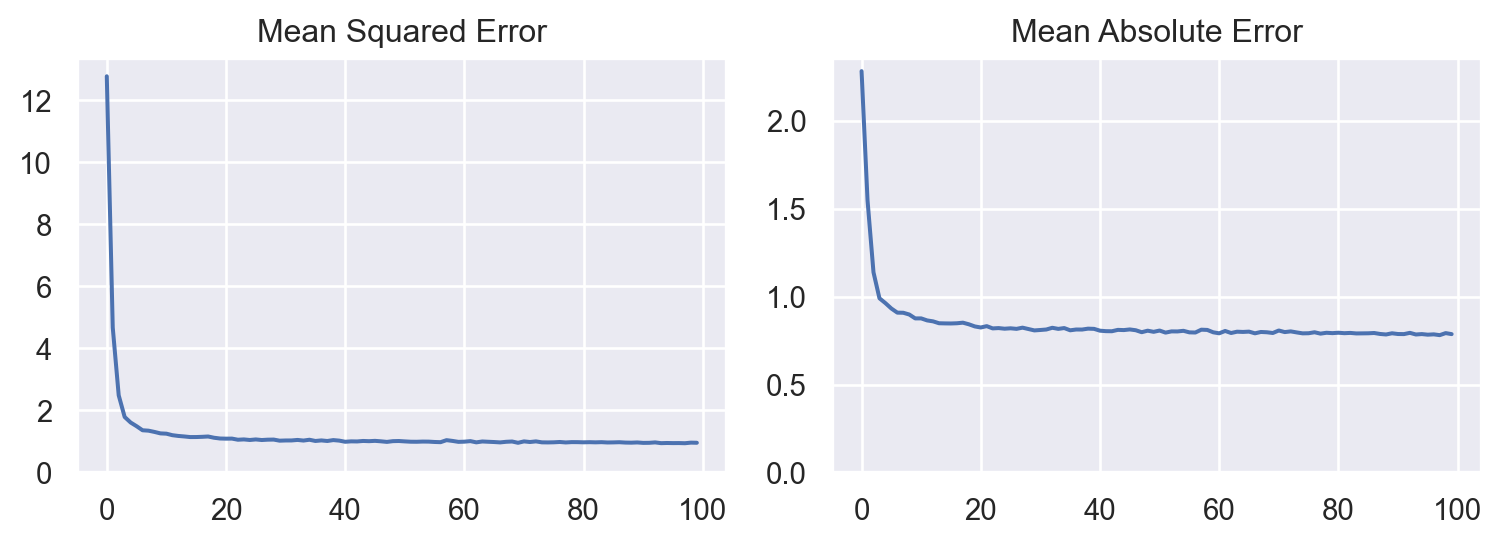

In [15]:
#| fig-align: center

history = model.fit(X_train, y_train, epochs = 100, verbose = 0)

data = pd.DataFrame(history.history)
data = data.reset_index()
data = data.rename(columns = {"index":"epoch", 
                              "loss": "Mean Squared Error", 
                              "mae": "Mean Absolute Error"})
data = pd.melt(data, 
               id_vars = "epoch", 
               value_vars = ["Mean Squared Error", "Mean Absolute Error"],
               var_name = "metric",
               value_name = "value")

(
    so.Plot(data, x = "epoch", y = "value")
    .facet("metric")
    .add(so.Line())
    .share(y = False)
    .limit(y = (0, None))
    .layout(size = (8, 3))
    .label(x = "", y = "")
)

In [16]:
mse, mae = model.evaluate(X_test, y_test, verbose = 0)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error : 1.04
Mean Absolute Error: 0.82


## Conclusion

In this post, I demonstrate how to leverage a small subset of TensorFlow 2 capabilities to deal with artificial datasets. Even though here only includes problems with structured data with well defined problems and boundaries, Deep Learning model in essence allows anyone to do Machine Learning for highly unstructured data such as images and texts. 